# Policy learning and Off-line policy evaluation

## Domain Adaptation: A perspective from Sensitivity Value: measurable covariates shift


- Edited and Completed : Jiaxu Ren

This code sample refers to some sub-domains of my research area: off-line policy reinforcement learning and domain adaptation.
the full doman adaptation expetiments can be seen in my Github repository: 3CRL


In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import torch
from torch import nn
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
import abc

from matplotlib import pyplot as plt
%matplotlib inline

## Outline

First we define the relevant data and policy objects and load a dataset based on the UCI Letter classification data.

4 parts:

**Learning a policy by learning a linear reward model (direct method)*

- This is done by me first. The direct method is to impute the missing(unobserved data). See we used the linear model to impute the rewards-however, the results are pretty off the right track because we are creating the simulation data just by using some overly randomized formulus. That indicates the linear parametric assumption does not hold perhaps.

Then we change our model to sigmoid, which seems better to fit the reward.
    
**Learning a policy by learning a log-linear policy model (IW, clipping, POEM)**

- 
    
**Considering the effects of model size with neural network models**

- 
    
**Comparing the various algorithms on different datasets**

- 
   

Note 1: Since we are using a classification dataset and converting it to a simulated bandit problem, we have access to the full reward vectors. We will split the data into train, val, and test sets. The train and val sets will not have access to the full rewards, but to reduce variance of the evaluation we will allow access to the full rewards on the test set. Note this is something we can do in this semi-synthetic data setting, but not something that can usually be done in the real world.

Note 2: This Document uses pytorch throughout. We have tried to avoid requiring you to fill in the more complicated parts (defining the models and training loops). But, if you are unfamiliar with pytorch it is worth going through this brief tutorial (https://pytorch.org/tutorials/beginner/basics/intro.html) and taking a look at the docs for any specific questions (https://pytorch.org/docs/stable/index.html).

# Instruction Space
To generalize the work we will be doing:
To do the simulation(the real data we get in the world), we need to generate the bandit feedback from the total feecback
This is done by the first function we will create. However, to generate bandit feedback, we also need a known policy because a bandit feedback is obtained by a policy we have played. Therefore the the **Bandit Feedback** function contains a policy function that selects action for us. 

Next, we have dataloader that helps us produce the data set for training,validation and test, respectively. Using this function, we also finish spliting the dataset. By randomly labling the data, we send **Bandit Feedback** to this function and take arguments such as policy type and data label to finally generate data we will be using for evaluation.

Until now, we are about to finish the local data pipeline and ready for train the data.
we have training data obtained from 2 defined functions. 

## Relevant Objects

The below code defines the objects that we need for the rest of the assignment to handle data and policies:

In [2]:
class BanditDataset:
    """
        Dataset object to simulate offline bandit feedback from 
        a classification dataset (X,y) and logging policy
    """
    def __init__(self, X, y, n_actions, logging_policy, 
                 seed=0):
        self.rng = default_rng(seed)
        self.X = X
        self.y = y
        self.n_actions = n_actions
        self.n_data = len(y)
        self.logging_policy = logging_policy
        
        # compute rewards
        self.full_rewards = 0.1 * np.ones((self.n_data, self.n_actions))
        for i in range(self.n_data):
            self.full_rewards[i,self.y[i]] = 0.9
        
        # sample actions from logging policy
        self.actions, self.probs = self.logging_policy.select_actions(self.X, self.rng)
            
        # compute rewards
        self.rewards = self.full_rewards[np.arange(self.n_data), self.actions]
        
    def sample_batch(self, batch_size):
        """
        Args:
            batch_size (int): size of batch to be sampled
        Returns:
            tuple of (contexts, actions, rewards, probs) of shapes
                    contexts: (batch_size, context_dim)
                    actions: (batch_size, )
                    rewards: (batch_size, )
                    probs: (batch_size, )
        """
        idx = self.rng.choice(self.n_data, size=batch_size)
        contexts = torch.tensor(self.X[idx], dtype=torch.float32)
        actions = torch.tensor(self.actions[idx], dtype=torch.int64)
        rewards = torch.tensor(self.rewards[idx], dtype=torch.float32)
        probs = torch.tensor(self.probs[idx], dtype=torch.float32)
        return contexts, actions, rewards, probs

In [3]:
def load_data(logging_name, train_size=2000):
    """
        Args:
            logging_name (str): name of the logging policy to be used
            train (bool): whether this is the train or test set
        Returns:
            BanditDataset based on UCI Letter data with the relevant logging policy 
    """
    assert train_size < 10001
    
    # load classification data
    df = pd.read_csv('data/letter-recognition.data', header=None)
    y = np.array([ord(l) - 65 for l in df[0]])
    X = np.array(df[list(range(1,17))])
    
    # split data
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[-10000:-9000]
    y_val = y[-10000:-9000]
    X_test = X[-9000:]
    y_test = y[-9000:]

    # load policy
    if logging_name == 'logistic':
        lr = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=10)
        n = 1000
        lr.fit(X_train[:n], y_train[:n])
        policy = PolicyModelPolicy(lr, 26)
    elif logging_name == 'uniform':
        policy = UniformPolicy(26)
    else:
        raise NotImplemented
        
    # create bandit datasets
    train_data = BanditDataset(X_train, y_train, 26, policy)
    val_data = BanditDataset(X_val, y_val, 26, policy)
    test_data = BanditDataset(X_test, y_test, 26, policy)
        
    # remove access to labels for train and val
    train_data.full_reward = None
    train_data.y = None
    val_data.full_reward = None
    val_data.y = None
        
    return train_data, val_data, test_data

In [4]:
class Policy:
    def __init__(self, num_actions=2):
        self.num_actions = num_actions

    @abc.abstractmethod
    def get_action_distribution(self, X):
        """   
        This method is intended to be overridden by each implementation of Policy.

        Args:
            X (pd.DataFrame): contexts

        Returns:
            2-dim numpy array with the same number of rows as X and self.num_actions columns. 
                Each rows gives the policy's probability distribution over actions conditioned on the context in the corresponding row of X
        """   
        raise NotImplementedError("Must override method")

    def get_action_propensities(self, X, actions):
        """   
        Args:
            X (pd.DataFrame): contexts, rows correspond to entries of actions
            actions (np.array): actions taken, represented by integers, corresponding to rows of X

        Returns:
            1-dim numpy array of probabilities (same size as actions) for taking each action in its corresponding context
        """   
        dist = self.get_action_distribution(X)
        n = X.shape[0]
        action_probs = dist[np.arange(n), actions ]
        return action_probs

    def select_actions(self, X, rng=default_rng(1)):
        """   
        Args:
            X (pd.DataFrame): contexts, rows correspond to entries of actions and propensities returned

        Returns:
            actions (np.array): 1-dim numpy array of length equal to the number of rows of X.  Each entry is an integer indicating the action selected for the corresponding context in X. 
                The action is selected randomly according to the policy, conditional on the context specified in the appropriate row of X.
            propensities (np.array): 1-dim numpy array of length equal to the number of rows of X; gives the propensity for each action selected in actions

        """   
        dist = self.get_action_distribution(X)
        n = X.shape[0]
        cdf = np.cumsum(dist, axis=1)
        tiled = np.tile(rng.random([n,1]), [1, self.num_actions])
        actions = np.argmax(tiled <= cdf, axis=1)
        propensities = dist[np.arange(n), actions]
        return actions, propensities


In [5]:
class UniformPolicy(Policy):
    """
        Uniformly random policy
    """
    
    def __init__(self, num_actions=2):
        self.num_actions = num_actions

    def get_action_distribution(self, X):
        action_distribution = np.full([X.shape[0], self.num_actions], 1/self.num_actions)
        return action_distribution

In [6]:
class PolicyModelPolicy(Policy):
    """
        Policy based on a policy_model that has a predict_proba method
    """
    
    def __init__(self, policy_model, num_actions, deterministic=False):
        self.num_actions = num_actions
        self.model = policy_model
        self.deterministic = deterministic
        
    def get_action_distribution(self, X):
        probs = self.model.predict_proba(X)
        
        if self.deterministic:
            probs = torch.tensor(probs)
            probs = nn.functional.one_hot(torch.argmax(probs, dim=1), 
                                          self.num_actions).detach().numpy()
            
        return probs

In [7]:
class RewardModelPolicy(Policy):
    """
        Policy based on a reward_model that has a predict method
    """
    
    def __init__(self, reward_model, num_actions):
        self.num_actions = num_actions
        self.model = reward_model
        
    def get_action_distribution(self, X):
        preds = self.model.predict(X)
        preds = torch.tensor(preds)
        probs = nn.functional.one_hot(torch.argmax(preds, dim=1), 
                                          self.num_actions).detach().numpy()
        return probs

In [8]:
def plot_loss(loss):
    """
        Function to plot smoothed learning curves
    """
    plt.plot(smooth(loss))
    plt.ylabel('loss')
    plt.xlabel('step')
    plt.show()

def smooth(arr, gamma = 0.9):
    new_arr = [arr[0]]
    for x in arr[1:]:
        new_arr.append(gamma * new_arr[-1] + (1-gamma) * x)
    return np.array(new_arr)

In [9]:
def evaluate_full_feedback(policy, dataset):
    """
        Function to evaluate policy on a test dataset that has full_rewards
        
        Args:
            policy (Policy): the policy to be evaluated
            dataset (BanditDataset): the dataset to use for evaluation (i.e. the test set)
        Returns:
            real-valued value estimate
    """
    action_probs = policy.get_action_distribution(dataset.X)
    expected_reward_per_context = np.sum(dataset.full_rewards * action_probs, axis=1)
    value_est = np.mean(expected_reward_per_context)
    
    return value_est

def evaluate_sniw(policy, dataset):
    """
        Function to evaluate policy on a validation dataset
        Uses a self-normalized estimator
        
        Args:
            policy (Policy): the policy to be evaluated
            dataset (BanditDataset): the dataset to use for evaluation (i.e. the validation set)
        Returns:
            real-valued value estimate
    """
    action_probs = policy.get_action_propensities(dataset.X, dataset.actions)
    weights = action_probs / dataset.probs

    value_est = np.sum(weights * dataset.rewards) / np.sum(weights)
    
    return value_est

## Load the data

In [10]:
num_actions = 26
context_dim = 16

log_type = 'logistic'
train_size = 2000

train_data, val_data, test_data = load_data(log_type, train_size)

## Method 1: direct method(Reg_imput)

### Defining the reward model

First we need a reward model. Here we implement a linear model in pytorch. We could use SKLearn for the linear model, but we will need to use gradient-based optimization later on for policy learning and to use neural models, so instead we will use pytorch throughout.

In [104]:
class LinearRewardModel(nn.Module):
    def __init__(self, context_dim, n_actions):
        super(LinearRewardModel, self).__init__()
        self.linear = nn.Linear(context_dim, n_actions)
    
    def forward(self, X):
        """
            Args: 
                X (torch.tensor): a tensor of shape (batch_size, context_dim) and dtype torch.float32
            Returns:
                a torch.tensor of shape (batch_size, n_actions) containing model predictions
        """
        #preds = self.linear(X)
        preds = torch.sigmoid(self.linear(X))
        return preds
    
    def predict(self, X):
        """
            Args: 
                X (np.ndarray): an array of shape (batch_size, context_dim)
            Returns:
                np.ndarray of shape (batch_size, n_actions) containing model predictions
        """
        #X = torch.tensor(X, dtype=torch.float32)
        return self.forward(X).detach().numpy()

### Defining the training loop

Since we are using pytorch, we need to define our own training loop. Here we will use the adam optimizer, a variant of SGD (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [60]:
def train(model, loss_fn, dataset, hyperparams):
    """
        Args: 
            model (nn.Module): a pytorch model with a forward method that takes contexts
            loss_fn (function): a function that takes torch.tensors of (preds, actions, rewards, propensities) 
                and returns a scalar torch.tensor loss
            dataset (BanditDataset): the training set
            hyperparams (dict): a dict of hyperparameter values. 
                    Needs to at least contain:
                        n_steps (int): the number of gradient steps to take
                        batch_size (int): the batch size for sampling SGD minibatches
                        lr (float): the learning rate for the adam optimizer
        Returns:
            list of training loss on each batch
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])
    
    losses = []
    for step in tqdm(range(hyperparams['n_steps'])):
        contexts, actions, rewards, propensities = dataset.sample_batch(hyperparams['batch_size'])
        loss = loss_fn(model.predict(contexts), actions, rewards, propensities, hyperparams)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return losses

### a: defining the learning objective

We will define the loss function for the direct method. The function takes in a batch (preds, actions, rewards, propensities) and returns a scalar tensor for the loss on this batch. Please note some inputs are in the form of *tensor* while some of *array*

In [102]:
def dm_loss(preds, actions, rewards, propensities, hyperparams):
       """
       Arg:
       preds: this is the imputed reward for each action under context X. Please remember this preds include full-imputed reward.
       actions: this is the actions vector taken by the policy we played in model argument
       rewards: this is the vector of observed rewards. 
       propensites: this is the vector of propensities of taken actions
       
       """
       actions = actions.numpy()
       rewards = rewards.numpy()
       propensities = propensities.numpy()
       preds = preds[range(hyperparams["batch_size"]),actions]
       estimated_dm_reward = np.matmul(preds,propensities)
       #estimated_dm_reward = preds*np.array(propensities)
       estimated_dm_loss = np.mean(np.square(estimated_dm_reward-rewards))/hyperparams['batch_size']
       estimated_dm_loss = torch.tensor(estimated_dm_loss,dtype=torch.float32,requires_grad=True)
       #return preds
       return estimated_dm_loss

In [107]:
hyperparams = {"n_steps":500,"batch_size":4,"lr":0.01}
contexts, actions, rewards, propensities = train_data.sample_batch(hyperparams['batch_size'])
preds = LinearRewardModel(context_dim=context_dim,n_actions=num_actions)
preds = preds.predict(contexts)
preds.shape
preds
preds[range(hyperparams['batch_size']),actions]
rewards.numpy()

array([0.9, 0.1, 0.9, 0.1], dtype=float32)

In [ ]:

dm_loss(LinearRewardModel(context_dim=context_dim,n_actions=num_actions),train_data.sample_batch(hyperparams['batch_size']))

### b: learning a policy

Now use the training loop to train the LinearRewardModel. Plot the learning curve with plot_loss. Then use evaluate_sniw and the validation set to estimate the value of the deterministic policy corresponding to the reward model you trained.
In the real-world case, we can try multiple different fitting models to see the results.Some further exploration might include: causal forest, recursive partitioning. 

But the underlying logic and machinary remains the same.

In [108]:
dm_lp = train(model=LinearRewardModel(context_dim=context_dim,n_actions=num_actions),loss_fn=dm_loss,dataset=train_data,hyperparams=hyperparams)

100%|██████████| 500/500 [00:00<00:00, 5318.25it/s]


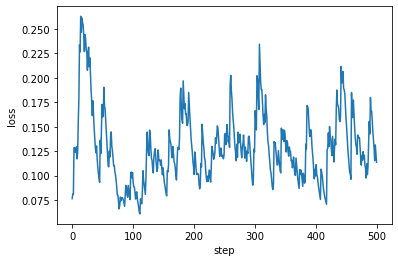

In [109]:
plot_loss(dm_lp)

In [115]:
policy_model = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=10).fit(val_data.X,val_data.actions)
played_policy = PolicyModelPolicy(policy_model=policy_model,num_actions=num_actions,deterministic=True)
evaluate_sniw(policy=played_policy,dataset=val_data)
evaluate_full_feedback(policy=played_policy,dataset=val_data)

0.6184000000000001

### Part c: tuning the hyperparameters

Using the validation set and the evaluate_sniw function defined above, you can tune the hyperparameters of the training loop including the number of steps, batch_size, and learning rate. Try some different settings and report your results. (Hint: try training for longer) 

Then after tuning on the validation set, report the value on the test set using the evaluate_full_feedback function. 